# Stereotype classification

## Inhaltsverzeichnis
...

## Einführung (Kalie)
...

## Daten (Kalie)
...

## Preselection & Annotation (Kalie)
- Kurz Vorgehen beschreiben, evlt. begründen

Stichwortliste mit 130 Stichworten, angelehnt an die aus Sánchez-Junquera 2021

- Annotationsrichtlinen geändert, warum? 

Wir haben uns bei der Erstellung der Annotationsrichtline an der aus Sánchez-Junquera 2021 orientiert. Bei der erstmaligen Bearbeitung der Aufgabe/bei der Erstellung des Korpus letztes Jahr(?) wurde klar, dass einige Frames und Kategorien in dem Korpus gar nicht vorkommen. Sie wurden deshalb weggelassen. 

- Stichwortliste geändert, warum?

länger als in S-J, umfasst 130 Stichworte (dabei einige auch doppelt, um verschiedene Deklinationen zu berücksichitigen, wäre evtl. nicht nötig gewesen), S-J hatte 60; basiert auf der aus S-J, wurde mit Stichworten aus den Bundestagsprotokollen erweitert (genauer ausführen) 


In [315]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from textblob_de import TextBlobDE
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

In [316]:
pd.set_option('display.max_colwidth', None)

In [317]:
nlp = spacy.load('de_core_news_sm')
de_stopwords = stopwords.words('german')

## Annotierte Daten laden

In [318]:
# Load annotated sentences
raw_df = pd.read_csv("data/combined_samples.csv", sep="\t")
raw_df.drop("Unnamed: 0", axis=1, inplace=True)
raw_df

,Term_NDoc_Date,Sentence,Frame
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1
...,...,...,...
495,18_121_2015-09-10,"Das sind die drei Integrationsaufgaben, die wir haben.",x
496,18_121_2015-09-10,Ich komme jetzt auch zum Thema Fluchtursachenbekämpfung.,x
497,18_121_2015-09-10,"Dass viele Mitbürger in unserem Land angesichts einer solchen Anzahl von Flüchtlingen Ängste haben und sich fragen, wie Bund, Länder und Kommunen die Unterbringung und auch die Integration bewältigen wollen, ist, wie ich glaube, nur allzu verständlich.",4
498,18_121_2015-09-10,"Denn nur wenn es gelingt, gemeinsam mit der Wirtschaft das Potenzial und die Motivation der Menschen, die zu uns kommen, zu nutzen, nur dann wird Integration gelingen.",3


### Klassenverteilung

In [319]:
# Number of sentences labeled with "x"
sum(raw_df["Frame"] == "x")

302

In [320]:
# Number of sentences labeled with a frame or a category
sum(raw_df["Frame"] != "x")

198

## Preprocessing (Kalie)
Für den Schritt des Preprocessing haben wir die Sätze tokenisiert, Groß/Kleinschreibung einheitlich gemacht (bzw. alle strings/tokens als lowercase gespeichert) und die Punktuation und Stoppwörter entfernt.

In [321]:
def preprocess(sent):
    # Tokenize
    doc = nlp(sent)
    tokens = [token.text for token in doc]
    # To lower
    tokens_lower = [t.lower() for t in tokens]
    # Remove punctuation and stopwords
    clean = [t for t in tokens_lower if t.isalpha() and t not in de_stopwords]
    return " ".join(clean)


def apply_preprocessing(sents):
    clean_sents = []
    for sent in sents:
        clean_sents.append(preprocess(sent))
    return np.array(clean_sents)

In [322]:
raw_sents = raw_df["Sentence"].to_numpy()
# Preprocess
sents = apply_preprocessing(raw_sents)
sents.size

500

## Vorüberlegungen & Ziele (Liane)
Sanchez et al. untersuchen in ihrem Paper, wie effektiv klassische ML-Modelle und SOA-Modelle mithilfe der erstellten Taxonomie und des darauf basierenden annotierten Korpus das Framing von Migrant\*innen klassifizieren können. Dabei werden zwei binäre Klassifikationsprobleme betrachtet:
- Enthält eine Aussage Stereotype über Migrant\*innen oder nicht? ("Stereotype vs. Nonstereotype")
- Angenommen, die Aussage enthält Stereotype: Werden Migrant\*innen als Opfer oder Bedrohung dargestellt? ("Victim vs. Threat")

Wir führen diese Aufgaben mit einem klassischen ML-Modell für überwachtes Lernen, der Support Vector Machine, durch. Wir nutzen, wie die Autor\*innen des Papers, die Implementation von Scikit-learn. Sanchez et al. trainieren die Modelle mit der tfidf-gewichteten Bag-of-words Repräsentation der Sätze. Es werden Unigramme, Bigramme und Trigramme verwendet, wobei Unigramme die besten Ergebnisse erzielen.
Im Rahmen dieses Projektes nutzen wir ebenfalls die Bag-of-words Repräsentation, wobei wir das Modell sowohl mit tfidf-Gewichtung als auch ohne tfidf-Gewichtung trainieren. Außerdem testen wir Sentiment als Feature. (Weitere Erklärungen zu ergänzen...)

In [323]:
# Array with original indexes so we can retrieve raw sentences later
orig_indexes = np.arange(raw_sents.size)
orig_indexes.size

500

## 1. Aufgabe: Stereotype vs. Keine Stereotype
Die Annotator\*innen wurden gebeten, die Aussagen über Migrant\*innen Frames zuzuordnen. Sanchez et al. erheben den Anspruch, dass die Taxonomie von Frames, vollständig die Dimensionen der Stereotypisierung von Migrant\*innen abbildet, sei sie positiv oder negativ.
Sätze, welche keinem Frame oder keiner Kategorie zugeordnet werden konnten, sollten mit "x" annotiert werden. 
Dem Datensatz wird eine Spalte "Contains stereotypes" mit den Goldlabels für die Klassifikation hinzugefügt. Sätze, welche mit "x" annotiert wurden, erhalten das Label 0 für "enthält keine Stereotype". Alle anderen Sätze erhalten 1 als Label.

In [324]:
def get_binary_labels(data):
    """Add column to df with binary labels for classification"""
    data.loc[data["Frame"] == "x", "Contains stereotypes"] = 0
    data.loc[data["Frame"] != "x", "Contains stereotypes"] = 1
    return data

In [325]:
df = get_binary_labels(raw_df)
df.head()

,Term_NDoc_Date,Sentence,Frame,Contains stereotypes
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x,0.0
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3,1.0
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1,1.0
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4,1.0
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1,1.0


In [326]:
# Get goldlabels
y = df["Contains stereotypes"].to_numpy()

### Extraktion von Features für überwachtes Lernen
#### 1. Bag-of-Ngrams ohne Tfidf-Gewichtung
Zunächst wandeln wir den Datensatz in seine Bag-of-words bwz. "Bag-of-ngrams" Repräsentation um. Jeder Satz wird also als Vektor dargestellt, dessen Werte die Counts aller im Datensatz vorkommenden Ngramme darstellen.

In [327]:
def get_ngram_count_matrx(sents, n):
    """Get ngrams and ngram count matrix"""
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_count_matrx = vectorizer.fit_transform(sents).toarray()
    ngrams = vectorizer.get_feature_names_out()
    return ngrams, ngram_count_matrx

In [328]:
unigrams, unigram_count_matrx = get_ngram_count_matrx(sents, 1)
bigrams, bigram_count_matrx = get_ngram_count_matrx(sents, 2)
trigrams, trigram_count_matrx = get_ngram_count_matrx(sents, 3)

In [329]:
# Number of unique unigrams, bigrams and trigrams
unigrams.size, bigrams.size, trigrams.size

(2457, 4371, 4091)

In [330]:
unigram_count_matrx.shape, bigram_count_matrx.shape, trigram_count_matrx.shape

((500, 2457), (500, 4371), (500, 4091))

#### 2. Bag-of-ngrams mit Tfidf-Gewichtung
Nun ziehen wir das Tfidf-Maß hinzu, um die Counts der Ngramme zu gewichten.

In [331]:
# Add weighing with tfidf
def transform_to_tfidf(ngram_count_matrx):
    transformer = TfidfTransformer()
    tfidf_matrx = transformer.fit_transform(ngram_count_matrx).toarray()
    return tfidf_matrx

In [332]:
unigram_tfidf_matrx = transform_to_tfidf(unigram_count_matrx)
bigram_tfidf_matrx = transform_to_tfidf(bigram_count_matrx)
trigram_tfidf_matrx = transform_to_tfidf(trigram_count_matrx)

In [333]:
unigram_tfidf_matrx.shape, bigram_tfidf_matrx.shape, trigram_tfidf_matrx.shape

((500, 2457), (500, 4371), (500, 4091))

#### 3. Sentiment Scores
Als letztes berechnen wir für jeden Satz noch den Sentiment score. Dafür nutzen wir das Package TextBlobDE.

In [334]:
def get_sentiment(sents):
    sentiment = []
    for sent in sents:
        blob = TextBlobDE(sent)
        sentiment.append(blob.polarity)
    return np.array(sentiment)

In [335]:
sentiment_scores = get_sentiment(sents).reshape(-1, 1)
sentiment_scores.shape

(500, 1)

In [336]:
# Create dicts with features
name2ngram_counts = {
    "Unigram counts": unigram_count_matrx,
    "Bigram counts": bigram_count_matrx, 
    "Trigram counts": trigram_count_matrx
}
name2ngram_tfidf = {
    "Unigram Tfidf": unigram_tfidf_matrx,
    "Bigram Tfidf": bigram_tfidf_matrx,
    "Trigram Tfidf": trigram_tfidf_matrx
}

### Trainieren und Evaluieren der Modelle

**Majority Baseline:**

In [337]:
# Train baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(sents, y)
acc = dummy_clf.score(sents,y)
print(f"Accuracy of majority baseline: {acc}")

Accuracy of majority baseline: 0.604


In [338]:
def train_model(X, y, orig_indexes, model):
    # Split into training and test data
    X_train, X_test, y_train, y_test, orig_train, orig_test = train_test_split(
    X, y, orig_indexes,
    test_size=0.2, 
    stratify=y, 
    random_state=10
    )
    # Fit model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    
    return y_test, y_pred, orig_test

def get_predictions(y_test, y_pred, orig_test):
    """Create dataframe with raw sents of test set and predictions from model"""
    predictions = []
    for i in range(len(y_pred)):
        predictions.append([raw_sents[orig_test[i]], y_pred[i], y_test[i]])
    predictions_df = pd.DataFrame(predictions, columns=["Raw sentence", "Predicted label", "Gold label"])
    
    return predictions_df

In [339]:
def get_correct(predictions):
    return predictions.loc[predictions["Predicted label"] == predictions["Gold label"]]

def get_wrong(predictions):
    return predictions.loc[predictions["Predicted label"] != predictions["Gold label"]]

In [340]:
def print_results(feature_dict):
    for name, features in feature_dict.items():
        y_test, y_pred, orig_test = train_model(features, y, orig_indexes, SVC())
        predictions = get_predictions(y_test, y_pred, orig_test)
        print(f"{name}:")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("\n")

### Ergebnisse

**1. Bag-of-ngrams ohne Tfidf-Gewichtung:**

In [341]:
print_results(name2ngram_counts)

Unigram counts:
              precision    recall  f1-score   support

         0.0       0.62      0.93      0.75        60
         1.0       0.60      0.15      0.24        40

    accuracy                           0.62       100
   macro avg       0.61      0.54      0.49       100
weighted avg       0.61      0.62      0.54       100



Bigram counts:
              precision    recall  f1-score   support

         0.0       0.61      0.95      0.74        60
         1.0       0.50      0.07      0.13        40

    accuracy                           0.60       100
   macro avg       0.55      0.51      0.44       100
weighted avg       0.56      0.60      0.50       100



Trigram counts:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.44       100
weighted avg       0.61

**2. Bag-of-ngrams mit Tfidf-Gewichtung:**

In [342]:
print_results(name2ngram_tfidf)

Unigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76        60
         1.0       1.00      0.05      0.10        40

    accuracy                           0.62       100
   macro avg       0.81      0.53      0.43       100
weighted avg       0.77      0.62      0.49       100



Bigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36      0.60      0.45       100



Trigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36   

**3. Sentiment:**

In [343]:
y_test, y_pred, orig_test = train_model(sentiment_scores, y, orig_indexes, SVC())
predictions = get_predictions(y_test, y_pred, orig_test)
print("Sentiment:")
print(classification_report(y_test, y_pred, zero_division=0))

Sentiment:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36      0.60      0.45       100



**4. Kombinationen von Features:**

Wir testen außerdem, ob eine Kombinationen von unterschiedlichen Features eine Verbesserung der Performance bewirkt.

In [344]:
def combine_features(*features):
    return np.concatenate(features, axis=1)

In [345]:
unigrams_sentiment = combine_features(unigram_count_matrx, sentiment_scores)
bigrams_sentiment = combine_features(bigram_count_matrx, sentiment_scores)
trigrams_sentiment = combine_features(trigram_count_matrx, sentiment_scores)

In [346]:
name2ngrams_sentiment = {
    "Unigram counts + Sentiment": unigrams_sentiment,
    "Bigram counts + Sentiment": bigrams_sentiment,
    "Trigram counts + Sentiment": trigrams_sentiment
}

**Bag-of-ngrams + Sentiment:**

In [347]:
print_results(name2ngrams_sentiment)

Unigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.63      0.95      0.75        60
         1.0       0.67      0.15      0.24        40

    accuracy                           0.63       100
   macro avg       0.65      0.55      0.50       100
weighted avg       0.64      0.63      0.55       100



Bigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.44       100
weighted avg       0.61      0.61      0.50       100



Trigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.

### Besten Ergebnisse genauer betrachten:
Wir schauen uns die Ergebnisse des besten Modells an, um detailliertere Einblicke zu erhalten.

In [348]:
# Best features: unigram counts
y_test, y_pred, orig_test = train_model(unigram_count_matrx, y, orig_indexes, SVC())
predictions = get_predictions(y_test, y_pred, orig_test)

**Konfusionsmatrix:**

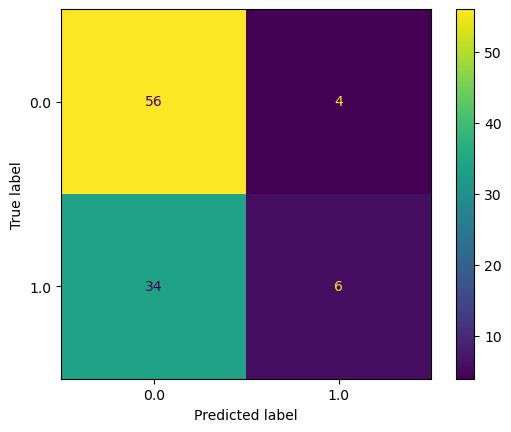

In [349]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

**Beispiele für korrekte Klassifizierungen:**

In [350]:
# Correct predictions
get_correct(predictions)

,Raw sentence,Predicted label,Gold label
1,"Ich nehme kein Beispiel aus dem Bereich des Terrorismus, der Kinderpornografie und auch nicht der Vergewaltigung, sondern ich nehme ein sehr praktisches Beispiel.",0.0,0.0
2,"Da die Zuwanderer solche familiären Netzwerke hier nicht haben, müssen sie sich auch diesbezüglich neu orientierten.",0.0,0.0
5,"Den Bundesinnenminister als denjenigen zu bezeichnen, der der Integration im Wege stand, heißt wirklich, das, was die Union in den letzten Jahren mit dieser Regierung getan hat, vollkommen zu verleugnen.",0.0,0.0
6,"Wir unterscheiden zwischen jenen, die wegen Krieg und Verfolgung Aussicht auf Asyl haben, und denen, die keine Chance auf eine Zukunft in Deutschland haben.",0.0,0.0
8,Innerhalb von acht Wochen wurden allein 28 000 Asylanträge von Menschen aus dem Kosovo gestellt.,0.0,0.0
...,...,...,...
92,"Dem gleichen Ziel dient die Aufforderung der Financial Action Task Force der OECD, jegliche Terrorismusfinanzierung unter Strafe zu stellen.",0.0,0.0
94,"Habe ich überhaupt eine Chance auf Asyl, wenn ich mein Leben aufs Spiel setze, wenn ich meine Familie, wenn ich meine Kinder verlasse?",0.0,0.0
95,"Auch wenn wir den Bürgerinnen und Bürgern ein Gefühl dafür geben wollen, dass wir mit der außenpolitischen Aufgabe der Bekämpfung der Fluchtursachen verantwortungsvoll umgehen, werden wir ihnen natürlich nicht für jedes Problem eine Lösung servieren können.",0.0,0.0
96,Eine ähnliche Schnittstellenfunktion erfüllt der Generalbundesanwalt beim Thema islamistischer Terrorismus.,0.0,0.0


**Beispiele für falsche Klassifizierungen:**

In [351]:
# Wrong predictions
get_wrong(predictions)

,Raw sentence,Predicted label,Gold label
0,"Solange Menschen keine andere Chance sehen, als über Schlepper und Menschenhändler nach Europa zu kommen, werden wir das Elend an unseren Grenzen nicht los.",0.0,1.0
3,"Aber während wir über unsere Willkommenskultur sprechen, brennen Unterkünfte für Flüchtlinge, werden Anschläge verübt.",0.0,1.0
4,"Nur wenn wir auch in den Herkunftsländern Fluchtursachen bekämpfen und wenn wir Fehlanreize in Deutschland beseitigen, dann werden wir unsere Kommunen dauerhaft und nachhaltig entlasten.",0.0,1.0
7,"Denn wie wollen Sie bitte schön erklären, dass man Syrer nicht nach Ungarn, Italien oder Bulgarien abschieben darf, eritreische oder irakische Flüchtlinge aber schon?",0.0,1.0
9,Einwanderung ist essenziell erforderlich für unsere Gesellschaft.,0.0,1.0
10,"Aber wenn wir das ernst meinen – wir meinen es alle ernst –, dass die Fluchtursachen langfristig nur in den Krisenregionen bekämpft werden können, dann müssen wir uns auch dazu bekennen, dass alle Etats in unserem Haushalt, die sich um die internationale Verantwortung kümmern – humanitäre Hilfe, Polizeiausbildung, wirtschaftliche Zusammenarbeit, aber auch der Etat für Verteidigung –, in den nächsten Jahren deutlicher anwachsen müssen, um dieser Verantwortung gerecht zu werden.",1.0,0.0
11,Damit können und sollen die Fluchtursachen in den wichtigsten Herkunftsländern zusätzlich bekämpft werden.,0.0,1.0
12,"Ich bin froh, dass wir die drei Sonderinitiativen haben, die von unserem Minister auf den Weg gebracht worden sind, nämlich „EineWelt ohne Hunger“, „Fluchtursachen bekämpfen – Flüchtlinge reintegrieren“ und „Stabilisierung und Entwicklung in Nordafrika und Nahost“, die es schon vorher gab, und dass wir die Mittel von 200 Millionen Euro auf 400 Millionen Euro verdoppeln konnten.",1.0,0.0
22,"Erst die wirtschaftliche Leistungskraft unseres Landes, gepaart mit soliden Finanzen, erspart uns jetzt schwere Entscheidungen und Konflikte darüber, wie wir die Aufnahme und die Integration so vieler Menschen in Deutschland schaffen und finanzieren wollen.",1.0,0.0
25,Über das novellierte Asylbewerberleistungsgesetz übernimmt der Bund jährlich Kosten von 43 Millionen Euro.,0.0,1.0


**Interpretation:** 

Warum scheitert das Modell in falschen Beispielen?

Ein möglicher Grund dafür, dass so oft fälschlicherwiese Keine Stereotype voraus gesagt werden, ist dass es verhältnisweise (3:2) mehr Daten für Nicht-Stereotype gibt als für Stereotype. 

Laut Sanchez et. al. lassen sich Stereotype nicht nur durch die Präsenz spezifischer Wörter erkennen. Das könnte erklären, warum oft ein Nicht-Stereotyp vorhergesagt wurde (warum?)

## Assoziation zwischen Ngrammen und Labels
Sanchez et al. argumentieren, dass Stereotype nicht nur in Form von Zuschreibungen negativer Attribute einer Personengruppe auftreten, sondern oft deutlich subtiler sind. Vielmehr zeichnen sich Stereotype durch das Framing, also durch das Narrativ und den Kontext, in welches die jeweilige Personengruppe platziert wird, aus. Indem das Framing von Migration/Migrant\*innen annotiert wird, sollen auch diejenigen Aussagen über Migrant\*innen, welche nicht auf den ersten Blick als stereotypisch erkennbar sind, identifiziert werden. 

Die Autor\*innen des Papers kommen auf einen interessanten Ansatz, in dem die Bereicherung der Sozialwissenschaften durch komputationelle Verfahren sichtbar wird. Sie berechnen für alle Ngramme (Bi- und Trigramme) den **PMI (Pointwise Mutual Information)** zu den jeweiligen Labels (also "Stereotype vs. Nonstereotype" bzw. "Victims vs. Threats"). PMI ist ein statistisches Maß, welches die Assoziation zwischen Ereignissen misst. Mit anderen Worten:  Zum einen untersuchen die Autor\*innen, welche Ngramme  am stärksten mit stereotypischen bzw. nicht-stereotypischen Aussagen assoziert sind. Zum anderen untersuchen sie welche Ngramme am stärksten mit pro-migrantischen Aussagen, welche Migrant\*innen als Opfer framen, assoziiert sind und welche Ngramme am stärksten mit anti-migrantischen Aussagen, in denen Migrant\*innen als Bedrohung dargestellt werden, assoziiert sind.
Ziel dabei ist, subtilere, nicht-triviale linguistische Muster automatisch zu ermitteln, welche zwar stark mit Stereotypen bzw. einer bestimmten Ausprägung von Stereotypen verbunden (also oft gleichzeitig mit ihnen auftreten), jedoch nicht für uns als solche ersichtlich sind.

Das wollen wir ebenfalls nachbilden.

**Wahrscheinlichkeit von Ngrammen berechnen:**

In [352]:
# Counts of total occurrences of ngrams
def count_ngrams(ngrams, ngram_count_matrx):
    ngram_counts = dict()
    for i, ngram in enumerate(ngrams):
        ngram_counts[ngram] = np.sum(ngram_count_matrx, axis=0)[i]
    return ngram_counts

# Get total number of ngrams
def get_total_count(ngram_counts):
    return sum(ngram_counts.values())

In [353]:
unigram_counts = count_ngrams(unigrams, unigram_count_matrx)
bigram_counts = count_ngrams(bigrams, bigram_count_matrx)
trigram_counts = count_ngrams(trigrams, trigram_count_matrx)

N_unigrams = get_total_count(unigram_counts)
N_bigrams = get_total_count(bigram_counts)
N_trigrams = get_total_count(trigram_counts)

In [354]:
# Compute ngram probability
def get_prob(ngram, ngram_counts, N_ngrams):
    return ngram_counts.get(ngram) / N_ngrams

**Beispiel:** Wahrscheinlichkeit von "terrorismus"

In [355]:
# Probability of occurrence of "terrorismus"
print("Probability of 'terrorismus':")
get_prob("terrorismus", unigram_counts, N_unigrams)

Probability of 'terrorismus':


0.005653021442495127

**Wahrscheinlichkeit der Kookkurrenz von Ngrammen und Labels berechnen:**

In [356]:
# Counts of cooccurrence of ngrams and labels
def count_ngram_label_cooccurrence(ngrams, ngram_count_matrx):
    ngram_label_cooccurrence = dict()
    for i in range(sents.size):
        for j in range(ngrams.size):
            tpl = (ngrams[j], y[i])
            if tpl in ngram_label_cooccurrence.keys():
                ngram_label_cooccurrence[tpl] += ngram_count_matrx[i, j]
            else:    
                ngram_label_cooccurrence[tpl] = ngram_count_matrx[i, j]
    return ngram_label_cooccurrence

In [357]:
unigram_label_coocc = count_ngram_label_cooccurrence(unigrams, unigram_count_matrx)
bigram_label_coocc = count_ngram_label_cooccurrence(bigrams, bigram_count_matrx)
trigram_label_coocc = count_ngram_label_cooccurrence(trigrams, trigram_count_matrx)

In [358]:
# Compute probability of cooccurrence of ngram and label
def get_coocc_prob(ngram, label, ngram_label_coocc, ngram_counts):
    return ngram_label_coocc.get((ngram, label)) / ngram_counts.get(ngram)

**Beispiel:** Wahrscheinlichkeit, dass "terrorismus" mit Label "0" bzw. Label "1" auftritt

In [359]:
# Probability of cooccurrence of "terrorismus" and label 0 (Contains no stereotypes)
print("Probability of 'terrorismus' occurring in sentence with label 0:")
get_coocc_prob("terrorismus", 0, unigram_label_coocc, unigram_counts)

Probability of 'terrorismus' occurring in sentence with label 0:


0.5862068965517241

In [360]:
# Example: Probability of cooccurrence of "terrorismus" and label 1 (Contains stereotypes)
print("Probability of 'terrorismus' occurring in sentence with label 1:")
get_coocc_prob("terrorismus", 1, unigram_label_coocc, unigram_counts)

Probability of 'terrorismus' occurring in sentence with label 1:


0.41379310344827586

**Berechnung der Pointwise Mutual Information (PMI):**

In [361]:
# Compute pmi (pointwise mutual information) of ngrams to each label
def get_ngram_label_pmi(ngram_label_coocc, ngram_counts, ngrams_total):
    """Computes the pmi for an ngram and labels 0 and 1 according to following formula:
    pmi(a, b) = log[P(a,b) / (P(a)*P(b))]
    """
    pmi_0, pmi_1 = dict(), dict()
    # Note: We're assuming that the probability of the labels are both 0.5 (like Sanchez et.al)
    # (like Sanchez et.al)
    p_label = 0.5
    for ngram, label in ngram_label_coocc.keys():
        p_ngram_label_coocc = get_coocc_prob(ngram, label, ngram_label_coocc, ngram_counts)
        p_ngram = get_prob(ngram, ngram_counts, ngrams_total)
        quot = p_ngram_label_coocc / (p_ngram * p_label)
        pmi = 0 if quot == 0 else log(quot)
        if label == 0:
            pmi_0[ngram] = pmi
        else:
            pmi_1[ngram] = pmi
            
    # Sort ngrams according to pmi
    sorted_pmi_0 = sorted(pmi_0.items(), key=lambda x: x[1], reverse=True)
    sorted_pmi_1 = sorted(pmi_1.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_pmi_0, sorted_pmi_1

In [362]:
unigrams_0_pmi, unigrams_1_pmi = get_ngram_label_pmi(unigram_label_coocc, unigram_counts, N_unigrams)
bigrams_0_pmi, bigrams_1_pmi = get_ngram_label_pmi(bigram_label_coocc, bigram_counts, N_bigrams)
trigrams_0_pmi, trigrams_1_pmi = get_ngram_label_pmi(trigram_label_coocc, trigram_counts, N_trigrams)

### Ergebnisse

**Bigramme, die am stärksten mit unstereotypischen Sätzen assoziiert sind:**

In [390]:
print("Bigrams most associated with label 0:")
bigrams_0_pmi[:10]

Bigrams most associated with label 0:


[('abgegeben notwendig', 9.133459327640225),
 ('abgegrenzt flüchtlinge', 9.133459327640225),
 ('abgelehnt wurde', 9.133459327640225),
 ('abgelehnte asylbewerber', 9.133459327640225),
 ('abgeschlossenen asylverfahren', 9.133459327640225),
 ('abgesprochen deren', 9.133459327640225),
 ('abriegeln weder', 9.133459327640225),
 ('absatz strafbarkeit', 9.133459327640225),
 ('abschaffen beibehalten', 9.133459327640225),
 ('abschieben abschrecken', 9.133459327640225)]

**Bigramme, die am stärksten mit stereotypischen Sätzen assoziiert sind:**

In [391]:
print("Bigrams most associated with label 1:")
bigrams_1_pmi[:10]

Bigrams most associated with label 1:


[('abgeordneten bündnisses', 9.133459327640225),
 ('abgestattet islamistischen', 9.133459327640225),
 ('abgleiten landes', 9.133459327640225),
 ('abgrenzung ausgrenzung', 9.133459327640225),
 ('ablehnen parallelgesellschaften', 9.133459327640225),
 ('abrede stellen', 9.133459327640225),
 ('absage erteilen', 9.133459327640225),
 ('abschaffung asylbewerberleistungsgesetzes', 9.133459327640225),
 ('abschieben darf', 9.133459327640225),
 ('abschieben finde', 9.133459327640225)]

### Interpretation
Aus der Liste von Bigrammen, die am stärksten mit Aussagen ohne Stereotype assoziiert sind, kann man eher wenig Information herausziehen. Bigramme wie "abgegrenzt flüchtlinge" oder "abschieben abschrecken" sind überraschend. Rein intuitiv und vielleicht ein wenig mit Weltwissen würden wir vermuten solche Bigramme in einem Kontext vorzufinden, in dem zum Beispiel die Asylpolitik kritisiert wird. Zumindest sind diese Bigramme nicht neutral. 
Betrachtet man die Bigramme, die am stärksten mit stereotypischen Aussagen assoziiert sind, zeigen sich ebenfalls Bigramme, die man nicht ganz klar nachvollziehen kann (z.B. "abgeordneten bündnisses"). 

Einige Bigramme nehmen wir allerdings auch als recht plausibel wahr. Ein Beispiel ist das Bigramm "abgestattet islamistischen". Das häufige Aufbringen von Islamismus im Zusammenhang mit Geflüchteten oder Migrant\*innen in rechtspopulistischen, anti-migrantischen Diskursen, die sich vor allem stereotypischen Bildern bedienen, ist bekannt. Auch, dass "ablehnen parallelgesellschaften" in der Liste auftaucht, erscheint plausibel. Ein stereotypisches Bild, welches oft gezeichnet wird, ist das der Migrant\*innen, die sich in Deutschland eine "Parallelgesellschaft" aufbauen, ohne den Willen sich in in die deutsche Gesellschaft zu integrieren. 

Insgesamt findet man jedoch nur punktuell Bigramme, welche sich klar mit unserer menschlichen Intuition vereinbaren lassen. Sanchez et al. sehen das in ihrem Paper als Indiz dafür, dass Stereotype sich nicht trivialerweise und intuitiv sprachlich charakterisieren lassen und argumentieren, dass komputationelle Verfahren deshalb interessante Erkenntnisse liefern können. Für unsere Studie wäre diese Schlussfolgerung deutlich zu weit hergeholt. Die sehr begrenzte Datenmenge lässt keine überzeugende Verallgemeinerung zu. Viele der Bigramme tauchen vermutlich alleinig aufgrund ihrer schieren Frequenz in den Listen auf und nicht, weil sie semantisch mit Stereotypen bzw. nicht mit Stereotypen assoziiert sind.

## 2. Aufgabe: Opfer vs. Bedrohung
Bei diesem Experiment geht es darum herauszufinden, ob das Modell es schafft, die Dimensionen der Stereotype von Aussagen richtig zu klassfizieren. Das Augenmerk von Sanchez et al. liegt hierbei insbesondere auf Aussagen, welche zwar als anti-migrantisch zu definieren sind, jedoch durch rhetorische Mittel von Politiker\*innen als solche unkenntlich gemacht werden. Menschliche Annotator\*innen schaffen es (in den meisten Fällen), solche Aussagen richtig einzuordnen. Die Frage ist, ob die getesteten Modelle auch dazu in der Lage sind.

Für diese Aufgabe erstellen wir einen Teil-Datensatz bestehend aus allen Aussagen, denen von den Annotator\*innen ein Frame oder eine Kategorie zugeordnet wurde. Sanchez et al. definieren die Suprakategorie "Opfer" als die Vereinigung von Kategorien 1 ("Opfer von Xenophobie") und Kategorie 2 ("Leidende Opfer") sowie die Suprakategorie "Bedrohung" als die Vereinigung von Kategorie 4 ("Gefahr für das Kollektiv"), Kategorie 5 ("Gefahr für Einzelne") und Kategorie 6 ("Entmenschlichung"). Kategorien 4 und 5 haben wir zusammengefasst, Kategorie 6 aufgrund fehlender Daten ausgeschlossen. Kategorie 3 ("Ökonomische Ressource") wurde für dieses Experiment von Sanchez et al. exkludidert, da zu wenig Daten vorlagen. Aus demselben Grund entschieden auch wir uns dazu, diese Kategorie nicht einzubeziehen. 
Letzendlich erhielten also alle Aussagen mit einem Frame < 3 das Label "1" für "Opfer" und alle Aussagen mit einem Frame > 3 das Label "0" für "Bedrohung.

In [365]:
# Create subset with all sentences containing stereotypes
stereotypes_df = raw_df.loc[raw_df["Frame"] != "x"].copy()

# Convert to float
stereotypes_df["Frame"] = stereotypes_df["Frame"].astype("float")

# Add binary goldlabels for classification task
stereotypes_df.loc[stereotypes_df["Frame"] < 3, "Victim"] = 1
stereotypes_df.loc[stereotypes_df["Frame"] > 3, "Victim"] = 0

In [366]:
# Examine the size of the new dataset
stereotypes_df.shape

(198, 5)

In [367]:
# Number of sentences where immigrants are framed as threats
sum(stereotypes_df["Victim"] == 0)

54

In [368]:
# Number of sentences in category 3 ("economic resource") 
stereotypes_df["Victim"].isnull().sum()

16

In [369]:
# Remove category 3
stereotypes_df.dropna(axis=0, inplace=True)
stereotypes_df.head()

,Term_NDoc_Date,Sentence,Frame,Contains stereotypes,Victim
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1,1.0,1.0
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4,1.0,0.0
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1,1.0,0.0
11,18_100_2015-04-23,"Die Mehrheit der deutschen Bevölkerung steht beispielhaft zu unserer Willkommenskultur, indem sie vor Ort auf vielfältige Weise die Ankunft und das Leben der Flüchtlinge begleitet und erleichtert.",1.5,1.0,1.0
12,18_100_2015-04-23,"Kolleginnen und Kollegen, das Recht auf Asyl ist und bleibt unantastbar.",1.1,1.0,1.0


In [370]:
# Get goldlabels
y = stereotypes_df["Victim"].to_numpy()

### Klassenverteilung

In [371]:
# Number of sentences where immigrants are labeled as victims
sum(stereotypes_df["Victim"] == 1)

128

In [372]:
# Number of sentences where immigrants are labeled as threats
sum(stereotypes_df["Victim"] == 0)

54

### Preprocessing

In [373]:
# Preprocess sentences 
raw_sents = stereotypes_df["Sentence"].to_numpy()
sents = apply_preprocessing(raw_sents)
sents.size

182

In [374]:
# Array with original indexes so we can retrieve raw sentences later
orig_indexes = np.arange(raw_sents.size)
orig_indexes.size

182

### Extraktion von Features für überwachtes Lernen

In [375]:
# Get ngram counts
unigrams, unigram_count_matrx = get_ngram_count_matrx(sents, 1)
bigrams, bigram_count_matrx = get_ngram_count_matrx(sents, 2)
trigrams, trigram_count_matrx = get_ngram_count_matrx(sents, 3)

unigrams.size, bigrams.size, trigrams.size

(1278, 1844, 1719)

In [376]:
# Get ngram counts with tfidf weights
unigram_tfidf_matrx = transform_to_tfidf(unigram_count_matrx)
bigram_tfidf_matrx = transform_to_tfidf(bigram_count_matrx)
trigram_tfidf_matrx = transform_to_tfidf(trigram_count_matrx)

unigram_tfidf_matrx.shape, bigram_tfidf_matrx.shape, trigram_tfidf_matrx.shape

((182, 1278), (182, 1844), (182, 1719))

In [377]:
# Get sentiment scores
sentiment_scores = get_sentiment(sents).reshape(-1, 1)
sentiment_scores.shape

(182, 1)

In [378]:
# Create dicts with features
name2ngram_counts = {
    "Unigram counts": unigram_count_matrx,
    "Bigram counts": bigram_count_matrx, 
    "Trigram counts": trigram_count_matrx
}
name2ngram_tfidf = {
    "Unigram Tfidf": unigram_tfidf_matrx,
    "Bigram Tfidf": bigram_tfidf_matrx,
    "Trigram Tfidf": trigram_tfidf_matrx
}

### Ergebnisse

**1. Bag-of-ngrams ohne Tfidf-Gewichtung:**

In [379]:
print_results(name2ngram_counts)

Unigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Bigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Trigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49

**2. Bag-of-ngrams mit Tfidf-Gewichtung:**

In [380]:
print_results(name2ngram_tfidf)

Unigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Bigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Trigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49   

**3. Sentiment:**

In [381]:
y_test, y_pred, orig_test = train_model(sentiment_scores, y, orig_indexes, SVC())
predictions = get_predictions(y_test, y_pred, orig_test)
print("Sentiment:")
print(classification_report(y_test, y_pred, zero_division=0))

Sentiment:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



### Ergebnisse genauer betrachten:
Wir schauen uns die Ergebnisse des besten Modells an, um detailliertere Einblicke zu erhalten.

**Konfusionsmatrix:**

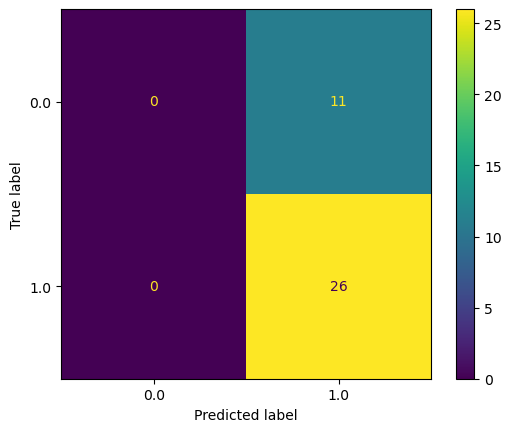

In [382]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Evaluation: Beispiele für Richtige/Falsche Vorraussagen
Warum scheitert das Modell in falschen Beispielen?
